## A/B Testing for Sales Conversion

#### 1. Import package and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats import power as pwr
from statsmodels.stats.proportion import proportion_confint, proportions_ztest, proportion_effectsize
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv("../data/raw/KAG_conversion_data.csv")
df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [3]:
def data_overview():
    # print('1. Data description: ')
    # print(df.describe(include='all'))  # Description of dataset
    print(f'1. Shape of dataset: {df.shape}')
    print('2. Columns datatype: ')
    for group, column in df.columns.to_series().groupby(df.dtypes):  # Datatype of each column
        print(group, end='\t| ')
        for name in column:
            print(name, end=', ')
        print()
    
data_overview()

1. Shape of dataset: (1143, 11)
2. Columns datatype: 
int64	| ad_id, xyz_campaign_id, fb_campaign_id, interest, Impressions, Clicks, Total_Conversion, Approved_Conversion, 
float64	| Spent, 
object	| age, gender, 


#### 2. Clean data

In [4]:
print("The number of 0-values in Clicks (given that Conversion are non-zero):", len(df[(df["Clicks"] == 0) & (df["Total_Conversion"] != 0)]))
df["Clicks"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=["gender", "age"])))

df["Clicks"] = df_imputed[5]

The number of 0-values in Clicks (given that Conversion are non-zero): 204


In [5]:
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype('str')
df['xyz_campaign_id'].unique()

array(['916', '936', '1178'], dtype=object)

In [6]:
df.drop(['ad_id', 'fb_campaign_id'], axis='columns', inplace=True)
df['CPC']=df['Spent']/df['Clicks']
df['CTR']=df['Clicks']/df['Impressions']
# df['converted']=df['Total_Conversion']/df['Impressions']

In [7]:
def check_missing_data(data: pd.DataFrame) -> pd.Series:
    """Check for missing data in the df (display in descending order)"""
    result = ((data.isnull().sum() * 100)/ len(data)).sort_values(ascending=False)
    return result

check_missing_data(df)

xyz_campaign_id        0.0
age                    0.0
gender                 0.0
interest               0.0
Impressions            0.0
Clicks                 0.0
Spent                  0.0
Total_Conversion       0.0
Approved_Conversion    0.0
CPC                    0.0
CTR                    0.0
dtype: float64

#### 3. Treatment and control group & guardrail check

In [8]:
df_control = df.loc[df['xyz_campaign_id']=='1178']
df_test = df[df['xyz_campaign_id']=='936']
cont_size = len(df_control['xyz_campaign_id'])
test_size = len(df_test['xyz_campaign_id'])
n = len(df)

In [9]:
# Guardrail Check on differences in proportions:
print('Does the control group proportion ' + str(cont_size/n) + ' lie within ' + str(proportion_confint(n/2, n, .05)) + '?')

Does the control group proportion 0.5468066491688539 lie within (0.471013553334954, 0.528986446665046)?


We've calculated 95% confidence intervals for our p̂_control does not lie within the CI. This means that we've failed our Guardrail Metric. The number of unique users is not equal for each group.

#### 4. Sample size & minimum detectable effect size

In [10]:
# Calculate retention rate mean and std
# retention_mean = df['CTR'].mean()  # total_subs_count / total_users_count
retention_mean = df_control["Clicks"].mean() / df_control["Impressions"].mean()

# # Calculate ratio
sizes = [cont_size, test_size]
ratio = max(sizes)/ min(sizes)

# Setting the parameters and we want to increase the purchase_mean to 0.1 in this experiment
effect_size = proportion_effectsize(retention_mean, retention_mean + 0.1)

# Initialize analysis and calculate sample size
ssresult = pwr.TTestIndPower().solve_power(effect_size, power=0.8, alpha=0.05, nobs1=None, ratio=ratio)
print(f'Sample Size: {int(ssresult)}')

Sample Size: 36


In [11]:
# Set parameters for entire dataset: The quantified magnitude of a result present in the population.
alpha = 0.05
power = 0.8
samp_size = int(ssresult)

# Initialize analysis & calculate effect size
analysis = pwr.TTestIndPower()
esresult = analysis.solve_power(effect_size = None, power = power, nobs1 = samp_size, ratio = ratio, alpha = alpha)
print(f'Minimum detectable effect size: {round(esresult,2)}')

Minimum detectable effect size: 0.62


#### 5. Proportional Z test & confidence interval
A two proportion Z-test is employed to examine any disparities between the proportions of two populations.

Two Proportion Z-Test Formula (left-tailed):
Hypothesis:
* $H_0: p_1 > p_2$
* $H_1: p_1 < p_2$

The test statistic z:
$z = \dfrac{p_1 - p_2}{\sqrt{p_{pool}(1-p_{pool})(\dfrac{1}{n_1} + \dfrac{1}{n_2})}}$
where $p_1$ and $p_2$ are the sample proportions, $n_1$ and $n_2$ are the sample sizes,
and where p is the total pooled proportion calculated as: $p_{pool} = \dfrac{(p_1 \cdot n_1 + p_2 \cdot n_2)}{(n_1+n_2)}$

When the p-value associated with the test statistic Z is less than the selected significance level of 0.05, we reject the null hypothesis.

In [12]:
ctr_control = df_control["Clicks"].sum() / df_control["Impressions"].sum()
ctr_test = df_test["Clicks"].sum() / df_test["Impressions"].sum()
print(ctr_control)
print(ctr_test)
print(ctr_control > ctr_test)

0.00017617100550992835
0.0002675873475843998
False


In [13]:
#returning the total number of conversions for each group:
clicks = np.array([df_control["Clicks"].sum(), df_test["Clicks"].sum()])
impressions = np.array([df_control["Impressions"].sum(), df_test["Impressions"].sum()])

test_stat, p_value = proportions_ztest(count=clicks, nobs=impressions, alternative="smaller")

print("H0: Distributions of both populations are equal.")
print("H1: Distributions of both populations are not equal.\n")
print(f"Z test statistic is {test_stat:.3f}")
print(f"p-value for Z test is {p_value:.3f}\n")

if p_value<alpha:
    print(f"p-value = {p_value:.3f} < {alpha}")
    print("We can reject null hypothesis. These groups are not similar. Users in Gate30 have higher 1 day retention than Gate40")
else:
    print(f"p-value = {p_value:.3f} >= {alpha}")
    print("We can't reject null hypothesis. These groups are similar.")

H0: Distributions of both populations are equal.
H1: Distributions of both populations are not equal.

Z test statistic is -19.071
p-value for Z test is 0.000

p-value = 0.000 < 0.05
We can reject null hypothesis. These groups are not similar. Users in Gate30 have higher 1 day retention than Gate40


In [14]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(count=clicks, nobs=impressions, alpha=0.05)

print(f'z statistic: {test_stat:.2f}')
print(f'p-value: {p_value:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -19.07
p-value: 0.000
ci 95% for control group: [0.000, 0.000]
ci 95% for treatment group: [0.000, 0.000]


#### 6. Cost per click

In [15]:
def hypothesis_result(df_A, df_B, col_name):
    test_stat_A, pvalue_A = shapiro(df_A[col_name])
    print('Shapiro Test Stat = %.4f, p-value = %.4f' % (test_stat_A, pvalue_A))

    test_stat_B, pvalue_B = shapiro(df_B[col_name])
    print('Shapiro Test Stat = %.4f, p-value = %.4f' % (test_stat_B, pvalue_B))

    test_stat_var, pvalue_var = levene(df_A[col_name], df_B[col_name])
    print('Levene Test Stat = %.4f, p-value = %.4f' % (test_stat_var, pvalue_var))

    if pvalue_A < 0.05 and pvalue_B < 0.05:
        test_stat, pvalue = mannwhitneyu(df_A[col_name], df_B[col_name])

        print('Mannwhitneye Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
        print(f'H0 hypothesis {"NOT REJECTED" if pvalue > 0.05 else "REJECTED"}')
    else:
        test_stat, pvalue = ttest_ind(df_A[col_name], df_B[col_name], equal_var=(True if pvalue_var > 0.05 else False))

        print('Ttest Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
        print(f'H0 hypothesis {"NOT REJECTED" if pvalue > 0.05 else "REJECTED"}')

In [16]:
hypothesis_result(df_control, df_test, 'CPC')

print('-------------------')

print('control_mean', df_control['CPC'].mean())
print('test_mean', df_test['CPC'].mean())

Shapiro Test Stat = 0.7064, p-value = 0.0000
Shapiro Test Stat = 0.7840, p-value = 0.0000
Levene Test Stat = 454.0077, p-value = 0.0000
Mannwhitneye Test Stat = 239584.0000, p-value = 0.0000
H0 hypothesis REJECTED
-------------------
control_mean 1.542301894429349
test_mean 0.8467419998162079


#### 7. Bootstrapping

'0.0%'

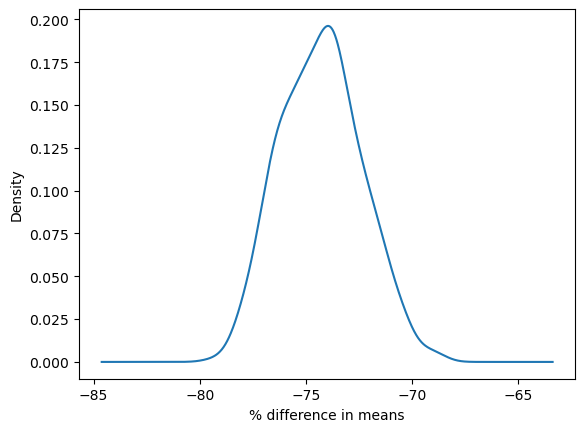

In [17]:
# Creating a list with bootstrapped means for each AB-group
boot_df = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('xyz_campaign_id')['CTR'].mean()
    boot_df.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_df = pd.DataFrame(boot_df, columns=['1178', '936'])
# Adding a column with the % difference between the two AB-groups
boot_df['diff'] = ((boot_df['1178'] - boot_df['936'])/boot_df['936']) * 100
# Ploting the bootstrap % difference
ax = boot_df['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_df['diff'] > 0 ).mean()
# Pretty printing the probability
'{:.1%}'.format(prob)

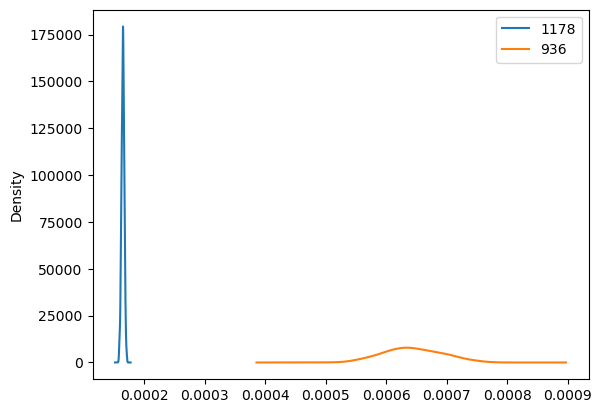

In [18]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_df[['1178', '936']].plot(kind = 'kde')
plt.show()